In [3]:
"""
Google Colab Training Script — BPE Transformer
================================================
Instructions:
1. Go to colab.research.google.com
2. Create a new notebook
3. Go to Runtime → Change runtime type → T4 GPU
4. Paste each section below into a separate cell and run them in order

Each "# === CELL N ===" comment marks where to split into a new Colab cell.
"""

# === CELL 1: Setup and clone your repo ===
# (Change the URL to YOUR GitHub repo)

!git clone https://github.com/adimunot21/transformer-from-scratch.git
%cd transformer-from-scratch
!pip install torch torchvision torchaudio  # GPU version (Colab default)
!pip install matplotlib tqdm numpy

# Verify GPU is available
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Cloning into 'transformer-from-scratch'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 40 (delta 12), reused 40 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 323.62 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/transformer-from-scratch/transformer-from-scratch/transformer-from-scratch
PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4


In [5]:
# === CELL 2: Train the BPE tokenizer (fast, ~1 min) ===
!curl -o data/input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
from src.bpe_tokenizer import BPETokenizer

with open("data/input.txt", "r") as f:
    text = f.read()

# Train with 512 merges this time (we have GPU power now!)
# vocab_size = 256 bytes + 512 merges = 768 tokens
tok = BPETokenizer()
tok.train(text, num_merges=512)
tok.save("data/bpe_tokenizer_512.json")

# Quick sanity check
sample = text[:200]
enc = tok.encode(sample)
dec = tok.decode(enc)
assert dec == sample, "Round-trip failed!"
print(f"\nChars: {len(sample)} → BPE tokens: {len(enc)} ({len(sample)/len(enc):.2f}x compression)")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  1988k      0 --:--:-- --:--:-- --:--:-- 1991k
Training BPE with 512 merges...
Initial chunks: 209,892
Initial tokens: 1,115,394
  Merge   50:      'e, ' (count=2,450) → token 305 | total tokens: 774,535
  Merge  100:       'di' (count=1,434) → token 355 | total tokens: 685,574
  Merge  150:       'de' (count=887) → token 405 | total tokens: 626,587
  Merge  200:     'him ' (count=662) → token 455 | total tokens: 589,234
  Merge  250:       'so' (count=518) → token 505 | total tokens: 560,027
  Merge  300:       'ON' (count=407) → token 555 | total tokens: 537,265
  Merge  350:       'mp' (count=322) → token 605 | total tokens: 519,488
  Merge  400:    'ER:\n' (count=275) → token 655 | total tokens: 504,666
  Merge  450:      'erv' (count=239) → token 705 | total tokens: 491,699
  Merge  500:     't

In [6]:
# === CELL 3: Updated dataset for BPE ===

from torch.utils.data import Dataset, DataLoader

class BPEDataset(Dataset):
    """Same as CharDataset but works with BPE token ids."""
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y


# Encode full text with BPE
all_tokens = tok.encode(text)
data = torch.tensor(all_tokens, dtype=torch.long)
print(f"Full text: {len(text):,} chars → {len(all_tokens):,} BPE tokens")

# Train/val split
split = int(len(data) * 0.9)
train_ds = BPEDataset(data[:split], block_size=256)
val_ds = BPEDataset(data[split:], block_size=256)
print(f"Train: {len(train_ds):,} samples | Val: {len(val_ds):,} samples")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True)

# Verify shapes
xb, yb = next(iter(train_loader))
print(f"Batch shapes: x={xb.shape}, y={yb.shape}")
print(f"Token range: min={xb.min().item()}, max={xb.max().item()}, vocab={tok.vocab_size}")



Full text: 1,115,394 chars → 477,624 BPE tokens
Train: 429,605 samples | Val: 47,507 samples
Batch shapes: x=torch.Size([64, 256]), y=torch.Size([64, 256])
Token range: min=10, max=767, vocab=768


In [7]:
# === CELL 4: Model — same architecture, bigger vocab ===

# We import our model directly from the cloned repo
from src.model import GPT
import math

# GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Slightly bigger model since we have GPU headroom
model = GPT(
    vocab_size=tok.vocab_size,  # 768 instead of 65
    d_model=192,                # Wider (was 128)
    n_heads=6,                  # More heads (was 4)
    n_layers=6,                 # Deeper (was 4)
    block_size=256,
    dropout=0.1,
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")
print(f"Vocab size: {tok.vocab_size}")

# Quick forward pass test
xb, yb = next(iter(train_loader))
xb, yb = xb.to(device), yb.to(device)
logits, loss = model(xb, yb)
print(f"Initial loss: {loss.item():.4f} (expected ~{math.log(tok.vocab_size):.4f})")


Training on: cuda
Model parameters: 3,010,944
Vocab size: 768
Initial loss: 6.6785 (expected ~6.6438)


In [8]:
# === CELL 5: Training loop ===

import time
import torch.nn.functional as F

# Hyperparameters
MAX_STEPS = 5000
WARMUP_STEPS = 500
LR = 3e-4
EVAL_INTERVAL = 250
EVAL_STEPS = 20
SAMPLE_INTERVAL = 500

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def get_lr(step):
    if step < WARMUP_STEPS:
        return LR * (step + 1) / WARMUP_STEPS
    progress = (step - WARMUP_STEPS) / (MAX_STEPS - WARMUP_STEPS)
    return LR * 0.5 * (1.0 + math.cos(math.pi * progress))

@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        total = 0.0
        it = iter(loader)
        for _ in range(EVAL_STEPS):
            try:
                xb, yb = next(it)
            except StopIteration:
                it = iter(loader)
                xb, yb = next(it)
            xb, yb = xb.to(device), yb.to(device)
            _, loss = model(xb, yb)
            total += loss.item()
        out[name] = total / EVAL_STEPS
    model.train()
    return out

def generate_sample(prompt="\n", length=200, temp=0.8):
    model.eval()
    tokens = tok.encode(prompt)
    ctx = torch.tensor([tokens], dtype=torch.long, device=device)
    out = model.generate(ctx, max_new_tokens=length, temperature=temp)
    model.train()
    return tok.decode(out[0].tolist())

# ---- Train! ----
print(f"Training for {MAX_STEPS} steps on {device}...")
print("-" * 60)

train_losses = []
val_losses = []
train_iter = iter(train_loader)
model.train()
t0 = time.time()

for step in range(MAX_STEPS):
    try:
        xb, yb = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        xb, yb = next(train_iter)

    xb, yb = xb.to(device), yb.to(device)

    lr = get_lr(step)
    for pg in optimizer.param_groups:
        pg["lr"] = lr

    _, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if step % EVAL_INTERVAL == 0 or step == MAX_STEPS - 1:
        losses = estimate_loss()
        elapsed = time.time() - t0
        print(
            f"Step {step:5d} | "
            f"train: {losses['train']:.4f} | "
            f"val: {losses['val']:.4f} | "
            f"lr: {lr:.2e} | "
            f"time: {elapsed:.1f}s"
        )
        train_losses.append(losses["train"])
        val_losses.append(losses["val"])

    if step > 0 and step % SAMPLE_INTERVAL == 0:
        sample = generate_sample()
        print(f"\n--- Sample at step {step} ---")
        print(sample)
        print("---\n")

elapsed = time.time() - t0
print(f"\nTraining complete in {elapsed:.1f}s")


Training for 5000 steps on cuda...
------------------------------------------------------------
Step     0 | train: 6.6759 | val: 6.6775 | lr: 6.00e-07 | time: 3.5s
Step   250 | train: 4.8800 | val: 4.9354 | lr: 1.51e-04 | time: 59.2s
Step   500 | train: 4.1044 | val: 4.2910 | lr: 3.00e-04 | time: 119.7s

--- Sample at step 500 ---

Sewrece!
Re your bjess abtetione, a brage your mother with you!

CE:
Or or father: I me.

GLOUCESTER:
So cce your father, if you deservands not ons,
Whose ake the sicious hence at the retends,
Lurnes,
As I graceight, I caity
Have their bansweepleadrs of yourong the poor fk, my memight of gen, as bed.

MULIFRES PULUS:
WARENCi Mons leaves, and take in the own and power;
For nause he have bek, by thy jo,
My lord, we coin
Let my hustraiolk bely dees
BAMARFOR
---

Step   750 | train: 3.7661 | val: 4.0563 | lr: 2.98e-04 | time: 182.8s
Step  1000 | train: 3.4499 | val: 3.8606 | lr: 2.91e-04 | time: 243.3s

--- Sample at step 1000 ---

Henerough by thy blood
You ar

Saved model to checkpoints/model_bpe_final.pt


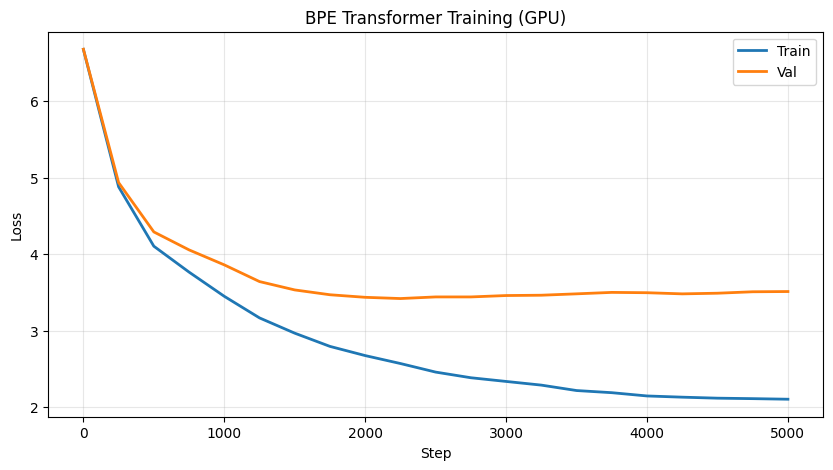

Saved loss plot to notebooks/bpe_training_loss.png


In [10]:
# === CELL 6: Save model and plot loss ===
import os
os.makedirs("checkpoints", exist_ok=True)
import matplotlib.pyplot as plt

# Save checkpoint
torch.save({
    "step": MAX_STEPS,
    "model_state": model.state_dict(),
    "config": {
        "d_model": 192, "n_heads": 6, "n_layers": 6,
        "block_size": 256, "dropout": 0.1,
    },
    "vocab_size": tok.vocab_size,
}, "checkpoints/model_bpe_final.pt")
print("Saved model to checkpoints/model_bpe_final.pt")

# Plot loss curves
steps = [i * EVAL_INTERVAL for i in range(len(train_losses))]
plt.figure(figsize=(10, 5))
plt.plot(steps, train_losses, label="Train", linewidth=2)
plt.plot(steps, val_losses, label="Val", linewidth=2)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("BPE Transformer Training (GPU)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("notebooks/bpe_training_loss.png", dpi=150)
plt.show()
print("Saved loss plot to notebooks/bpe_training_loss.png")


In [11]:

# === CELL 7: Generate and compare ===

print("=" * 60)
print("GENERATION SAMPLES — BPE MODEL")
print("=" * 60)

prompts = ["ROMEO:", "KING HENRY", "To be or not", "First Citizen:\n"]
for p in prompts:
    print(f"\n--- Prompt: '{p}' ---")
    print(generate_sample(prompt=p, length=300, temp=0.8))

# Temperature comparison
print("\n" + "=" * 60)
print("TEMPERATURE COMPARISON — Prompt: 'ROMEO:'")
print("=" * 60)
for temp in [0.3, 0.8, 1.0, 1.5]:
    print(f"\n--- temp={temp} ---")
    print(generate_sample(prompt="ROMEO:", length=200, temp=temp))


GENERATION SAMPLES — BPE MODEL

--- Prompt: 'ROMEO:' ---
ROMEO:--

KING RICHARD II:
Our live, as I shall not see my want
That I was my rapt with fearful dear as found;
The oracle, I appear a power,
Sushape as this like a flining sort boar,
Dreathe last in a white revenges my court
You by the pledge and servant friends!
Then, since I send a subject, and breath,
Where I come to Clarence, and quickly born,
That I have brought the end of death, and not regal it.

QUEEN ELIZABETH:
Please you to hear you shall believe your brother's love?
And now the day was the majesty of your daughter.

KING RICHARD III:
Cousin, say to me with my oath, much and truth
With speedy sensel of earthful time
Is my brother fortune for this duke shall suppound.

KING RICHARD III:
Sweet Poor King Henry, and thou blows the king:
And wherefore thou 

--- Prompt: 'KING HENRY' ---
KING HENRYORK:
Tridam, not the battle clouds on the crown.

WARWICK:
From for affection, and he that he that came
As the house, whom the kin

In [12]:

# === CELL 8 (Optional): Download checkpoint and tokenizer ===
# Uncomment these lines to download files to your local machine

from google.colab import files
files.download("checkpoints/model_bpe_final.pt")
files.download("data/bpe_tokenizer_512.json")
files.download("notebooks/bpe_training_loss.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
files.download("data/bpe_tokenizer_512.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>